# 抛物方程

## 固定区域

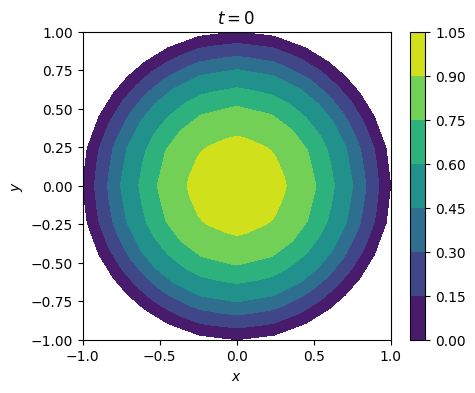

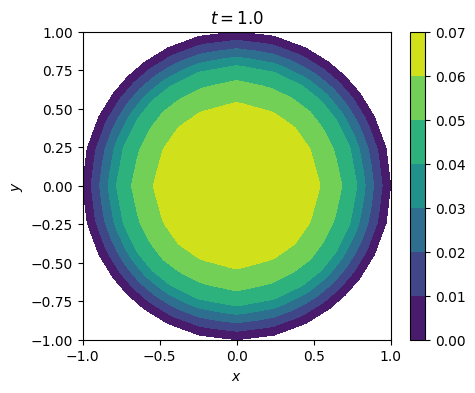

In [64]:
from firedrake import *
from firedrake.pyplot import tricontourf
import matplotlib.pyplot as plt


def plot_solution(u_h, time=None, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=[5, 4])
    if vmin is None or vmax is None:
        levels = None
    else:
        levels = np.linspace(vmin, vmax, 11)
    cs = tricontourf(u_h, axes=ax, levels=levels)
    ax.set_aspect('equal')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    if time is not None:
        ax.set_title(f'$t={time}$')
    cbar = fig.colorbar(cs)


T = 1
M = 32
dt = 1/M
t = Constant(0)

a = Constant(1)
b = Constant([0, 0]) # (2) # as_vector([0, 0]) # vector([0, 0, 0])

mesh = UnitDiskMesh(2)
# mesh = Mesh(gmshfile)
x, y = SpatialCoordinate(mesh)
f = x**2 + y**2
u_0 = 1 - x**2 - y**2

V = FunctionSpace(mesh, 'CG', 1)
u_trial, u_test = TrialFunction(V), TestFunction(V)
u_n = Function(V, name='u_n')
u_h = Function(V, name='u_h')

bc = DirichletBC(V, 0, 'on_boundary')

A = (
    1/dt*(u_trial - u_n)*u_test*dx
    + inner(grad(u_trial), b*u_test)*dx
    + inner(a*grad(u_trial), grad(u_test))*dx
    - f*u_test*dx
)

problem = LinearVariationalProblem(lhs(A), rhs(A), u_h, bcs=bc)
solver = LinearVariationalSolver(problem)

u_h.project(u_0)
# u_h.interpolate(u_0)
u_n.assign(u_h)

plot_solution(u_h, time=0)

# output = VTKFile('result.pvd', adaptive=True)
# output.write(u_h, time=0)

for i in range(M):
    t.assign((i+1)*dt)
    solver.solve()
    u_n.assign(u_h)
    # output.write(u_h, time=(i+1)*dt)

plot_solution(u_h, time=M*dt)

## 移动边界问题

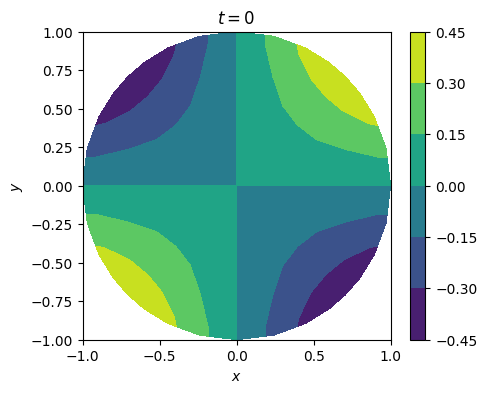

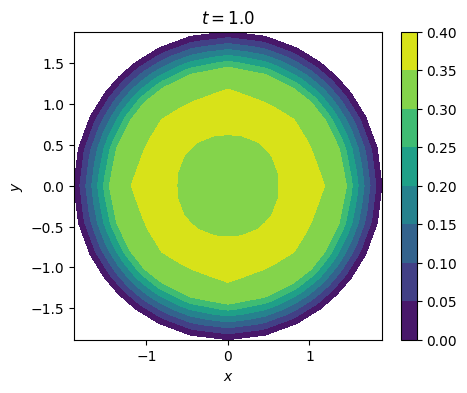

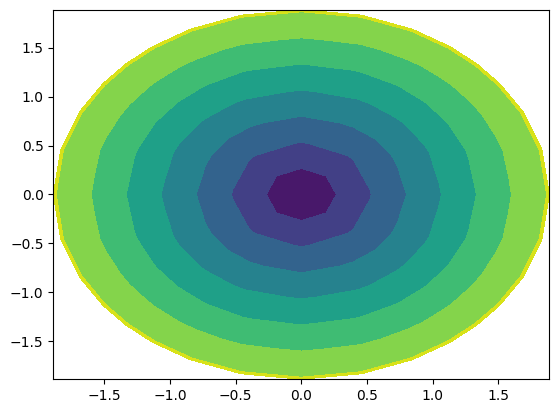

In [ ]:
from firedrake import *
from firedrake.pyplot import tricontourf
import matplotlib.pyplot as plt


def plot_solution(u_h, time=None, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=[5, 4])
    if vmin is None or vmax is None:
        levels = None
    else:
        levels = np.linspace(vmin, vmax, 11)
    cs = tricontourf(u_h, axes=ax, levels=levels)
    ax.set_aspect('equal')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    if time is not None:
        ax.set_title(f'$t={time}$')
    cbar = fig.colorbar(cs)


T = 1
M = 32
dt = 1/M

a = Constant(1)
b = as_vector([0, 0]) # vector([0, 0, 0])

t = Constant(0)

mesh = UnitDiskMesh(2)
# mesh = Mesh(gmshfile)
x, y = SpatialCoordinate(mesh)
f = x**2 + y**2
u_0 = sin(x)*sin(y)
v = as_vector([x, y])*exp(-t)

V_coords = VectorFunctionSpace(mesh, 'CG', 1)
w_vel = Function(V_coords)

V = FunctionSpace(mesh, 'CG', 1)
u_trial, u_test = TrialFunction(V), TestFunction(V)
u_n = Function(V, name='u_n')
u_h = Function(V, name='u_h')

bc = DirichletBC(V, 0, 'on_boundary')

A = (
    1/dt*(u_trial - u_n)*u_test*dx
    + inner(grad(u_trial), u_test*(b - w_vel))*dx
    + inner(a*grad(u_trial), grad(u_test))*dx
    - f*u_test*dx
)

problem = LinearVariationalProblem(lhs(A), rhs(A), u_h, bcs=bc)
solver = LinearVariationalSolver(problem)

w_trial, w_test = TrialFunction(V_coords), TestFunction(V_coords)
bc_move_mesh = DirichletBC(V_coords, v, 'on_boundary')
B = inner(grad(w_trial), grad(w_test))*dx - Constant(0)*w_test[0]*dx

mm_problem = LinearVariationalProblem(lhs(B), rhs(B), w_vel, bcs=bc_move_mesh)
mm_solver = LinearVariationalSolver(mm_problem)

u_h.project(u_0)
# u_h.interpolate(u_0)
u_n.assign(u_h)

# output = VTKFile('result.pvd', adaptive=True)
# output.write(u_h, time=0)

plot_solution(u_h, time=0)

for i in range(M):
    t.assign((i+1)*dt)

    mm_solver.solve()
    mesh.coordinates.assign(mesh.coordinates + dt*w_vel)

    solver.solve()
    u_n.assign(u_h)
    # output.write(u_h, time=(i+1)*dt)

plot_solution(u_h, time=M*dt)